In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from torch.utils.data import Dataset, DataLoader
from uni2ts.model.moirai.encoder_model import LinearProbing, EncoderModel, Pretraining

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai.convert import _convert
import os

In [3]:
len(os.listdir('data_pretrain_cache'))

46811

In [4]:
class RNSDataloader(Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_names = os.listdir(self.root_dir)
        self.patch_size_int = 128
        self.random_mask_ratio = 0.5

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        loaded_npy = np.load(os.path.join(self.root_dir, self.file_names[idx]), allow_pickle=True).item()
        
        data = torch.as_tensor(loaded_npy['data']).to(dtype=torch.float32)
        if loaded_npy['label'] is None:
            label = torch.zeros_like(data).to(dtype=torch.float32)
        else:
            label = torch.as_tensor(loaded_npy['label'], dtype=torch.int)
        

        return data, label, self.patch_size_int

In [5]:
def padding_sequence(sequences):
    max_seq_len = max([seq.size(0) for seq in sequences])
    max_feature_size = max([seq.size(1) for seq in sequences])
    padded_sequences = torch.zeros(len(sequences), max_seq_len, max_feature_size)
    padding_mask = torch.ones(len(sequences), max_seq_len, max_feature_size)
    for i, seq in enumerate(sequences):
        seq_len, feature_size = seq.size()
        padded_sequences[i, -seq_len:, :feature_size] = seq
        padding_mask[i, -seq_len:, :feature_size] = 0
    
    return padded_sequences, padding_mask

def comb(data):
    data, label, patch_size_int = zip(*data)

    # data = list(data)
    # data[0] = data[0][:,:3]
    # label = label
    patch_size_int = patch_size_int
    
    # [print(dt.shape) for dt in data]

    pad_sequence, pad_mask = padding_sequence(data)
    
    pad_label = torch.nn.utils.rnn.pad_sequence(label, batch_first=True, padding_value=-1)

    past_target = pad_sequence.to(dtype=torch.float32)
    past_observed_target = pad_mask.to(dtype=torch.bool) !=1
    past_is_pad = pad_mask.to(dtype=torch.bool)
    
    target, observed_mask, sample_id, time_id, variate_id, prediction_mask = _convert(
        context_length=pad_sequence.shape[1],
        patch_size=patch_size_int[0],
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad, )
        # 
    # print('target', target.shape)
    # print('observed_mask', observed_mask.shape)
    # print('sample_id', sample_id.shape)
    # print('time_id', time_id.shape)
    # print('variate_id', variate_id.shape)
    # print('prediction_mask', prediction_mask.shape)
    # print('label.shape', label.shape)
    
    patch_size = torch.full((target.shape[0], target.shape[1]), patch_size_int[0])
    
    # channel_univariate assumed
    patched_label, _, _, _, _, _ = _convert(
        context_length=pad_label.shape[1],
        patch_size=patch_size_int[0],
        past_target=pad_label,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad, )
    
    patched_label = (patched_label == 1).any(dim=2)
    
    batch_number = torch.zeros_like(prediction_mask, dtype=torch.int)
    for i in range(len(batch_number)):
        batch_number[i, :] = i
    
    # print(patched_label.shape)
    # print(pad_label.shape)
    # print(pad_label.unsqueeze(-1).shape)
    # print(past_is_pad[:,:,0].unsqueeze(-1).shape)
    # print(patched_label.shape)
    
    assert patched_label.shape[1]== target.shape[1]

    return (target, observed_mask, sample_id, time_id, variate_id, prediction_mask, patch_size), patched_label, batch_number


# past_target = data.unsqueeze(0).to(dtype=torch.float32)
# past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)[:, :, 0]
# 
# target, observed_mask, sample_id, time_id, variate_id, prediction_mask = _convert(
#     context_length=len(data),
#     patch_size=patch_size_int,
#     past_target=past_target,
#     past_observed_target=past_observed_target,
#     past_is_pad=past_is_pad, )


# return target, observed_mask, sample_id, time_id, variate_id, prediction_mask, label

In [6]:
dataset = RNSDataloader('data_pretrain_cache')
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=comb)
data_zip, label, batch_number = next(iter(dataloader))
target, observed_mask, sample_id, time_id, variate_id, prediction_mask, patch_size = data_zip

In [9]:
batch_number

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 2,  2,  2,  ...,  2,  2,  2],
        ...,
        [13, 13, 13,  ..., 13, 13, 13],
        [14, 14, 14,  ..., 14, 14, 14],
        [15, 15, 15,  ..., 15, 15, 15]], dtype=torch.int32)

In [8]:
valid_mask_indices = torch.nonzero(sample_id == 1)

In [7]:
dataset = RNSDataloader('data_cache')
val_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=comb)
data_zip, label, batch_number = next(iter(dataloader))

In [10]:
def generate_symmetrical_mask(sample_id, prediction_mask):
    # Find indices where sample_id_tensor equals 1
    valid_indices = torch.nonzero(sample_id == 1)
    total_valid_indices = len(valid_indices)

    # Randomly select half of the valid indices
    half_size = total_valid_indices // 2
    selected_random_indices = torch.randperm(total_valid_indices)[:half_size]

    # Create boolean masks for splitting the valid indices
    mask1_selector = torch.zeros(total_valid_indices, dtype=torch.bool)
    mask1_selector[selected_random_indices] = True
    mask2_selector = ~mask1_selector

    # Initialize output masks with the same shape as full_mask
    mask1 = torch.zeros_like(prediction_mask, dtype=torch.bool)
    mask2 = torch.zeros_like(prediction_mask, dtype=torch.bool)

    # Apply the selected and complementary indices to their respective masks
    mask1[valid_indices[mask1_selector][:, 0], valid_indices[mask1_selector][:, 1]] = True
    mask2[valid_indices[mask2_selector][:, 0], valid_indices[mask2_selector][:, 1]] = True

    return mask1, mask2

In [69]:
generate_symmetrical_mask(sample_id, prediction_mask)

(tensor([[ True,  True, False,  ..., False,  True, False],
         [False, False, False,  ..., False,  True,  True],
         [False, False,  True,  ...,  True,  True, False],
         [ True,  True, False,  ...,  True,  True, False]]),
 tensor([[False, False,  True,  ...,  True, False,  True],
         [False, False, False,  ...,  True, False, False],
         [ True,  True, False,  ..., False, False,  True],
         [False, False,  True,  ..., False, False,  True]]))

In [74]:
from uni2ts.common.torch_util import mask_fill, packed_attention_mask

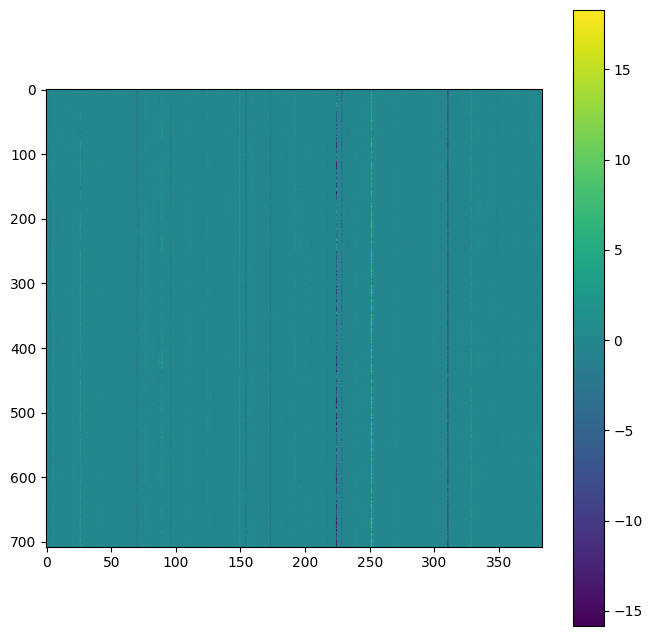

In [149]:
plt.figure(figsize=(8,8))
plt.imshow(encoded.detach()[0])
plt.gca().set_aspect(0.5)
plt.colorbar()
plt.show()

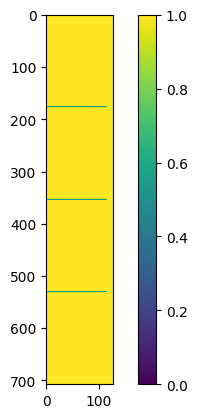

In [10]:
plt.imshow(observed_mask[0])
plt.gca()
plt.colorbar()
plt.show()

In [8]:
encoder = Pretraining.load_from_checkpoint("lightning_logs/version_67/checkpoints/epoch=52-step=310156.ckpt", encoder = EncoderModel(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"))).encoder

In [9]:
model = LinearProbing(encoder)

In [7]:
model = Pretraining(EncoderModel(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small")))

In [42]:
target, observed_mask, sample_id, time_id, variate_id, prediction_mask, patch_size = data_zip
mask_1, mask_2 = generate_symmetrical_mask(sample_id, prediction_mask)
prediction_mask = mask_1
loc, scale = model.model.scaler(target, observed_mask * ~prediction_mask.unsqueeze(-1),
                                        sample_id,
                                        variate_id, )

scaled_target = (target - loc) / scale
reprs = model.model.in_proj(scaled_target, patch_size)
masked_reprs = mask_fill(reprs, prediction_mask,model.model.mask_encoding.weight)
encoded = model.model.encoder(
    masked_reprs,
    packed_attention_mask(sample_id),
    time_id=time_id,
    var_id=variate_id,
)

AttributeError: 'Pretraining' object has no attribute 'model'

In [154]:
encoded[mask_1]

torch.Size([352, 384])

In [169]:
scaled_target[mask_1]

tensor([[-0.6289, -0.5180, -0.6592,  ...,  0.8234,  0.8940,  0.9545],
        [ 0.4805,  0.6520,  0.7528,  ..., -0.0440,  0.0468, -0.0238],
        [ 0.0670,  0.0367, -0.1246,  ..., -0.5684, -0.5079, -0.5079],
        ...,
        [ 0.0572,  0.0771,  0.1170,  ...,  0.3161,  0.7344,  0.6547],
        [ 0.5153,  0.7144,  0.7344,  ..., -0.0424, -0.1419, -0.4407],
        [-0.4805, -0.1818,  0.1170,  ..., -0.2017, -0.1220, -0.2017]])

In [190]:
y_pred_fft = torch.fft.fft(target[mask_1], dim=-1)
y_pred_amplitude = torch.abs(y_pred_fft)             # Amplitude spectrum
y_pred_phase = torch.angle(y_pred_fft)  

In [191]:
mean = torch.mean(y_pred_amplitude, dim=(1), keepdim=True)
std = torch.std(y_pred_amplitude, dim=(1), keepdim=True)
y_pred_amplitude = (y_pred_amplitude - mean) / std

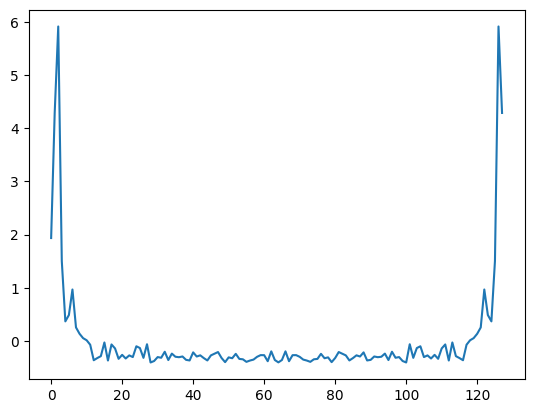

In [193]:
plt.plot(y_pred_amplitude[8])

In [174]:
y_pred_amplitude[0]

tensor([13.8455, 13.0882,  1.5718, 31.6864, 14.3554, 10.8996,  6.2218,  2.2069,
         4.2716,  5.6870,  1.1143,  1.5741,  5.5060,  3.5154,  0.2501,  2.3857,
         3.2027,  3.3474,  2.4159,  1.1478,  2.8625,  2.5339,  1.2213,  1.0759,
         1.5795,  1.2429,  0.7645,  1.3699,  1.5221,  1.9421,  0.9405,  1.7646,
         0.9987,  1.1555,  0.7433,  0.8456,  0.7438,  0.8327,  1.7853,  1.3883,
         0.2683,  0.8944,  0.9111,  0.8403,  0.2769,  1.1883,  0.8694,  0.8333,
         1.1035,  1.1145,  0.7548,  0.6550,  1.1566,  1.1798,  1.2099,  1.5446,
         1.0097,  0.9431,  1.1635,  0.7282,  0.6420,  0.9538,  1.2184,  0.7946,
         1.3817,  0.7946,  1.2184,  0.9538,  0.6420,  0.7282,  1.1635,  0.9431,
         1.0097,  1.5446,  1.2099,  1.1798,  1.1566,  0.6550,  0.7548,  1.1145,
         1.1035,  0.8333,  0.8694,  1.1883,  0.2769,  0.8403,  0.9111,  0.8944,
         0.2683,  1.3883,  1.7853,  0.8327,  0.7438,  0.8456,  0.7433,  1.1555,
         0.9987,  1.7646,  0.9405,  1.94

In [ ]:
x_fft = torch.fft.fft(x, dim=-1)
amplitude = torch.abs(x_fft)
amplitude = self.std_norm(amplitude)
angle = torch.angle(x_fft)
angle = self.std_norm(angle)

In [88]:
mask_1.shape

torch.Size([4, 708])

In [140]:
encoded_rep = EncoderModel(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base"))(data_zip)
print("encoded_rep", encoded_rep.shape)
print('label', label.shape)

encoded_rep torch.Size([32, 708, 768])
label torch.Size([32, 708])


In [8]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

csv_logger = CSVLogger('log', name='pretraining')
checkpoint_callback = ModelCheckpoint('pretrain_ckpt')
trainer = L.Trainer(logger=csv_logger, precision="16-mixed")
trainer.fit(model=model, train_dataloaders=dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Patrick Xu\Desktop\uni2ts\venv\lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | encoder   | EncoderModel | 13.8 M | train
1 | fc1_1     | Linear       | 98.6 K | train
2 | fc2_1     | Linear      

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Patrick Xu\Desktop\uni2ts\src\uni2ts\module\attention.py:296: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [33]:
predictions = trainer.predict(model,val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Patrick Xu\Desktop\uni2ts\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
output_list = []
target_list = []
emb_list = []
data_zip_list = []
for data_zip, emb, y, pred in predictions:
    data_zip_list.append(data_zip)
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

pred_raw = torch.vstack(output_list)
target = torch.concat(target_list)
emb = torch.concat(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [24]:
target_list[8]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [29]:

rearrange(data_zip_list[8][0][0], '(s p) f -> s (p f)', s = 4)

torch.Size([4, 22656])

In [38]:

import matplotlib.patches as patches
def plot_data(dt, label, pred, patch_size=128, dr=450):
    n_samples, n_rows = dt.shape[0], dt.shape[1]
    h, w = n_rows * 2, 20

    y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

    plt.figure(figsize=(w, h))
    ax = plt.axes()

    eeg_data = dt.T + y_tick_offsets[:, np.newaxis]

    plt.plot(eeg_data.T, 'k', linewidth=0.1)

    plt.yticks(y_tick_offsets)
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    plt.xlabel('Time (s)')
    
    start_index = n_samples % patch_size
    # Use numpy's arange and reshape to get the indices
    indices = np.arange(start_index, n_samples+1, patch_size)
    
    # print(eeg_data.min(), eeg_data.max())
    # print(y_tick_offsets - dr, y_tick_offsets + dr)
    
    total_range = eeg_data.max() - eeg_data.min()
    
    for i in range(1, label.shape[0]):
        for ch in range(label.shape[1]):
            if label[i, ch] == 1:
                x_min = indices[i-1]
                x_max = indices[i]
                y_min = y_tick_offsets[ch] - dr/2
                y_max = y_tick_offsets[ch] + dr/2
                width = x_max - x_min
                height = y_max - y_min
                
                # Create a rectangle and add it to the plot
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='None', facecolor='r', alpha=0.3)
                ax.add_patch(rect)
                
    for i in range(1, pred.shape[0]):
        for ch in range(pred.shape[1]):
            if pred[i, ch] == 1:
                x_min = indices[i-1]
                x_max = indices[i]
                y_min = y_tick_offsets[ch] - dr/2
                y_max = y_tick_offsets[ch] + dr/2
                width = x_max - x_min
                height = y_max - y_min
                
                # Create a rectangle and add it to the plot
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='None', facecolor='gold', alpha=0.3)
                ax.add_patch(rect)
    
    # Draw vertical lines to indicate patches
    plt.vlines(indices, np.min(eeg_data), np.max(eeg_data), linewidth=0.2)  
    
    plt.show()

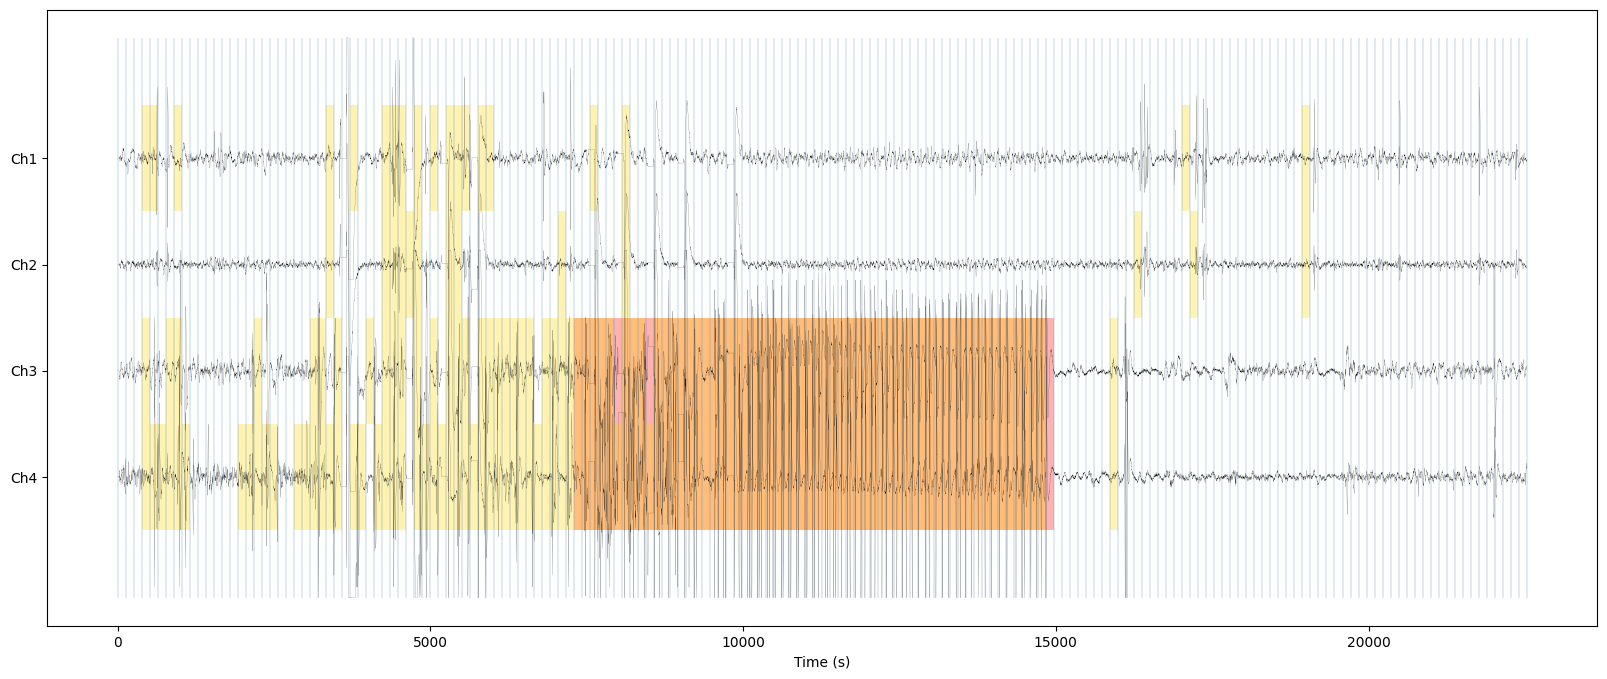

In [54]:
id =110
plot_data(rearrange(data_zip_list[id][0][0], '(s p) f -> s (p f)', s = 4).numpy().T, 
          rearrange(target_list[id], '(s p) -> s p', s = 4).numpy().T,
          rearrange(output_list[id].argmax(1), '(s p) -> s p', s = 4).numpy().T)

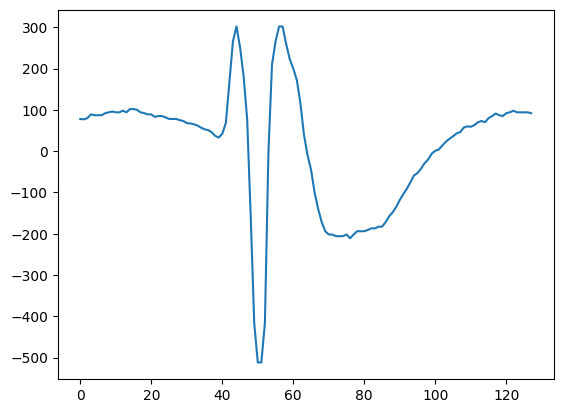

In [56]:
to_show = data_zip_list[id][0][0][460]
plt.plot(to_show)

In [57]:
y_pred_fft = torch.fft.fft(to_show)  # Complex tensor
y_pred_amplitude = torch.abs(y_pred_fft)             # Amplitude spectrum
y_pred_phase = torch.angle(y_pred_fft)               # Phase spectrum

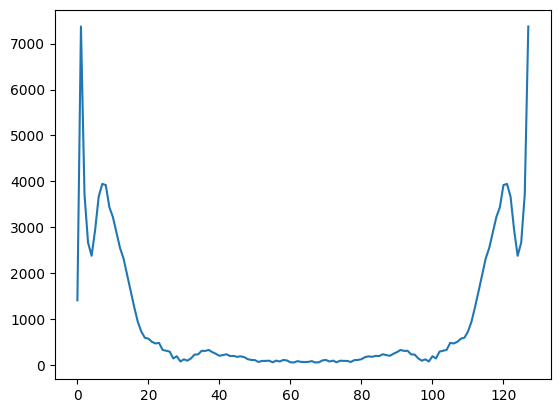

In [58]:
plt.plot(y_pred_amplitude)

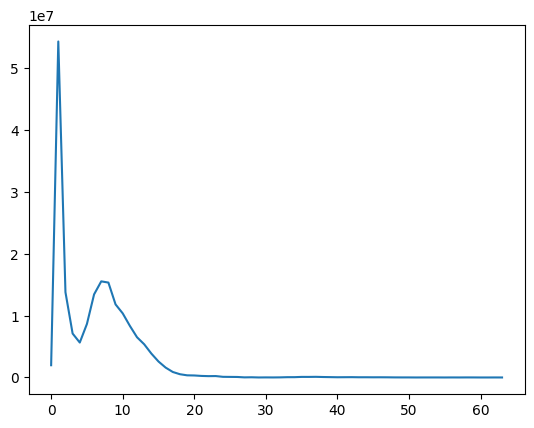

In [59]:
psd = torch.abs(y_pred_fft) ** 2
    
# Return the PSD, typically we are only interested in the first half of the FFT result due to symmetry
psd = psd[:len(psd) // 2]

plt.plot(psd)

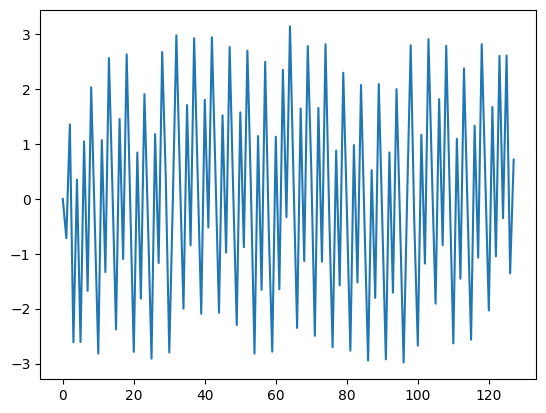

In [60]:
plt.plot(y_pred_phase)

In [ ]:
data_zip_list[id][0][0][460]

tensor([ 3.1416, -0.7252, -1.0421, -1.0357, -0.5469, -1.0620, -1.1986, -1.8053,
         2.3974, -2.0404, -1.6662, -1.3229, -2.1033, -1.8548, -1.0961, -1.0650,
        -1.3012, -1.1966, -0.1325, -2.6321, -1.2484, -1.8897, -0.5236, -1.9342,
        -1.6375, -0.5702, -0.8073, -1.1474, -0.1827, -0.7142, -1.5825,  1.1572,
         0.2030, -1.3667, -0.6147, -1.8241, -0.6089, -0.4570, -0.9866, -0.1633,
        -0.5742, -2.0923,  0.7064, -0.2331, -1.6884, -1.2051, -3.0549, -0.0916,
         0.6091,  0.9169, -1.8809, -0.1880, -1.2058, -1.1164,  0.4693, -0.1647,
         0.1182, -0.4173, -1.9723,  1.2001, -0.2998,  0.4550, -0.2803,  2.5232,
         0.0000, -2.5232,  0.2803, -0.4550,  0.2998, -1.2001,  1.9723,  0.4173,
        -0.1182,  0.1647, -0.4693,  1.1164,  1.2058,  0.1880,  1.8809, -0.9169,
        -0.6091,  0.0916,  3.0549,  1.2051,  1.6884,  0.2331, -0.7064,  2.0923,
         0.5742,  0.1633,  0.9866,  0.4570,  0.6089,  1.8241,  0.6147,  1.3667,
        -0.2030, -1.1572,  1.5825,  0.71

In [197]:
output_list[id].argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [192]:
target_list[id].shape

torch.Size([708])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.006s...
[t-SNE] Computed neighbors for 15000 samples in 1.478s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sa

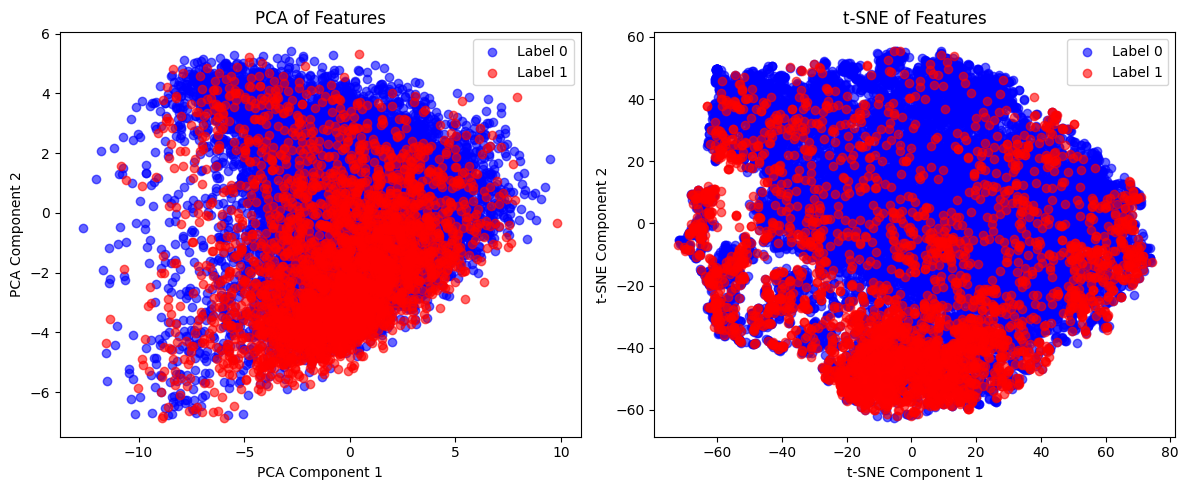

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

n_sampled = 15000  # Further reduce the number of samples for faster t-SNE iteration
sampled_indices = np.random.choice(len(emb), n_sampled, replace=False)


features = emb[sampled_indices]
labels = target[sampled_indices]

# features = emb_list[id]
# labels = target_list[id]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

# Perform t-SNE and reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42, verbose=True, perplexity=50)
tsne_result = tsne.fit_transform(features)

# Plot PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[labels == 0, 0], pca_result[labels == 0, 1], label='Label 0', alpha=0.6, c='blue')
plt.scatter(pca_result[labels == 1, 0], pca_result[labels == 1, 1], label='Label 1', alpha=0.6, c='red')
plt.title('PCA of Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[labels == 0, 0], tsne_result[labels == 0, 1], label='Label 0', alpha=0.6, c='blue')
plt.scatter(tsne_result[labels == 1, 0], tsne_result[labels == 1, 1], label='Label 1', alpha=0.6, c='red')
plt.title('t-SNE of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import classification_report
clf_report = classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.967036  0.906747  0.935922    718360
           1   0.635987  0.840539  0.724094    139244

    accuracy                       0.895997    857604
   macro avg   0.801511  0.873643  0.830008    857604
weighted avg   0.913285  0.895997  0.901528    857604


In [38]:
emb_list[id].shape

torch.Size([176, 384])

In [24]:
output_list[id].argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
rearrange(data_zip_list[8][3][0], '(s p) -> s p', s = 4)

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

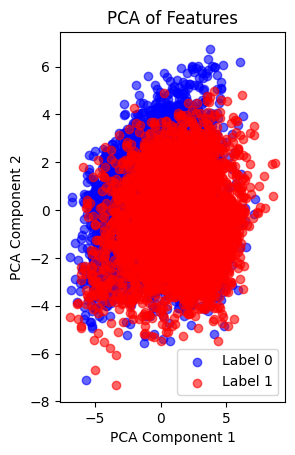

In [26]:
plt.subplot(1, 2, 1)
plt.scatter(pca_result[labels == 0, 1], pca_result[labels == 0, 2], label='Label 0', alpha=0.6, c='blue')
plt.scatter(pca_result[labels == 1, 1], pca_result[labels == 1, 2], label='Label 1', alpha=0.6, c='red')
plt.title('PCA of Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

In [14]:
len(features)

214401

In [147]:
import torch

# Example data tensor (batch, channel, feature)
data = encoded_rep
# Example mask tensor (batch, channel)
mask = sample_id.to(dtype = torch.bool)  # Mask with 0 or 1

unmasked_data = []
for batch_n in range(data.shape[0]):
    dt = data[batch_n][mask[batch_n]]
    t_id = time_id[batch_n][mask[batch_n]]
    reformatted = rearrange(dt, '(s t) f -> s t f', t=t_id[-1]+1)
    # pooled = reformatted.mean(dim=0)
    unmasked_data.append(reformatted)

torch.concat(unmasked_data, dim=0).shape
    
    
# Reshape the mask to (batch, channel, 1) to match the feature dimension
# mask = mask.unsqueeze(-1)  # Shape becomes (batch, channel, 1)
# 
# # Apply the mask to the data tensor
# # If mask is 1, keep the data; if mask is 0, zero out the data
# reverted_data = data * mask
# reverted_data.shape

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 177 but got size 176 for tensor number 3 in the list.

In [149]:
encoded_rep[mask].shape

torch.Size([22288, 768])

In [143]:
label.shape

torch.Size([32, 708])

In [148]:
label[mask].shape

torch.Size([22288])

In [47]:
data.shape

torch.Size([4, 708, 384])

In [59]:
4*708

2832

In [62]:
data[0][mask[0].to(dtype = torch.bool)]

tensor([[-2.1582e-03, -1.9423e-01, -8.6278e-01,  ..., -2.5223e-02,
         -6.8945e-03,  4.0867e-01],
        [-9.2605e-04, -8.1680e-02, -7.7746e-01,  ...,  3.5050e-02,
         -9.6348e-03,  8.9802e-01],
        [ 1.4878e-03, -1.7106e-01,  4.1478e-01,  ...,  4.5400e-02,
         -2.3977e-02,  4.3666e-01],
        ...,
        [ 3.9636e-03,  1.5117e-01, -7.8863e-01,  ...,  1.7126e-02,
          8.0065e-03,  5.0338e-02],
        [ 1.8110e-03,  2.0762e-01, -4.1982e-02,  ...,  4.4686e-02,
         -2.9072e-02, -1.4106e+00],
        [ 7.2071e-03, -6.7578e-02, -1.1881e+00,  ...,  2.6707e-02,
         -2.9194e-02,  5.1403e-01]], grad_fn=<IndexBackward0>)

In [63]:
time_id[0][mask[0].to(dtype = torch.bool)].shape

torch.Size([531])

In [64]:
torch.set_printoptions(threshold=10_000)
variate_id[0][mask[0].to(dtype = torch.bool)]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [86]:
sample_id !=1

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

In [41]:
batch_size = 2
num_channels = 3
num_features = 4
data = torch.randn(batch_size, num_channels, num_features)

print(data)
# Example mask tensor (batch, channel)
mask = torch.randint(0, 2, (batch_size, num_channels), dtype=bool)  # Mask with 0 or 1
print(mask)

unmasked_2d_list = []

# Iterate over batch and channel
for i in range(data.shape[0]):  # Iterate over the batch
    batch_list = []
    for j in range(data.shape[1]):  # Iterate over the channels
        # Use boolean indexing to select only the unmasked features
        unmasked_features = data[i, j, :][mask[i, j].bool()]
        
        # Append the unmasked features to the batch list (as 1D array)
        batch_list.append(unmasked_features)
    
    # Append the batch's unmasked features (for all channels) to the main list
    unmasked_2d_list.append(batch_list)
unmasked_2d_list

tensor([[[-0.3747,  0.3113, -0.1519,  0.4210],
         [ 1.1708,  0.3984,  1.4276,  0.4098],
         [ 2.2757,  0.8169,  2.2972,  0.0532]],

        [[ 0.3415, -0.6810,  0.5304, -0.2367],
         [-0.0692,  1.0335,  0.6931, -1.0832],
         [ 2.2682,  0.8047, -0.7035,  2.3152]]])
tensor([[False,  True, False],
        [ True,  True, False]])


[[tensor([], size=(0, 4)),
  tensor([[1.1708, 0.3984, 1.4276, 0.4098]]),
  tensor([], size=(0, 4))],
 [tensor([[ 0.3415, -0.6810,  0.5304, -0.2367]]),
  tensor([[-0.0692,  1.0335,  0.6931, -1.0832]]),
  tensor([], size=(0, 4))]]

In [49]:
batch_size = 2
num_channels = 3
num_features = 4
data = torch.randn(batch_size, num_channels, num_features)

print(data, data.shape)
# Example mask tensor (batch, channel)
mask = torch.randint(0, 2, (batch_size, num_channels), dtype=bool)  # Mask with 0 or 1
print(mask, mask.shape)

tensor([[[ 0.2609, -0.0130,  0.1540,  0.4801],
         [-0.0832, -0.0362,  0.5675,  1.9766],
         [ 0.1069,  0.1927, -0.2099,  0.8211]],

        [[ 1.2959, -0.7459,  1.0666, -0.5324],
         [ 0.3541,  1.1205, -0.0973, -0.0133],
         [-0.0877, -0.1151, -0.1681, -0.7348]]]) torch.Size([2, 3, 4])
tensor([[False, False,  True],
        [ True,  True,  True]]) torch.Size([2, 3])


In [50]:
data[mask]

tensor([[ 0.1069,  0.1927, -0.2099,  0.8211],
        [ 1.2959, -0.7459,  1.0666, -0.5324],
        [ 0.3541,  1.1205, -0.0973, -0.0133],
        [-0.0877, -0.1151, -0.1681, -0.7348]])

In [65]:
num_channel = int(label.shape[1])
reformatted = rearrange(encoded_rep, 'b (s t) f -> b s t f', t=num_channel)
pooled = reformatted.mean(dim=1)
pooled.shape

torch.Size([4, 177, 384])

In [38]:
sample_id_reformat = rearrange(sample_id, 'b (s t) -> b s t ', s=num_channel)
sample_id_reformat.shape

torch.Size([4, 4, 177])

In [30]:
label.shape
(label == 1).any(dim=2).long().shape

torch.Size([4, 176])

In [151]:
encoded_rep.shape

torch.Size([4, 708, 384])

In [142]:
label.shape

torch.Size([4, 177, 128])

In [144]:
sample_id.view(4, 4, 177)[0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
pad_mask

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `EncoderModel`

In [137]:
sample_id[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [135]:
test_label = label[0][sample_id[0][:label[0].shape[0]] == 1]

In [136]:
(test_label == 1).any(dim=1).long().shape

torch.Size([120])

TypeError: Invalid shape (704,) for image data

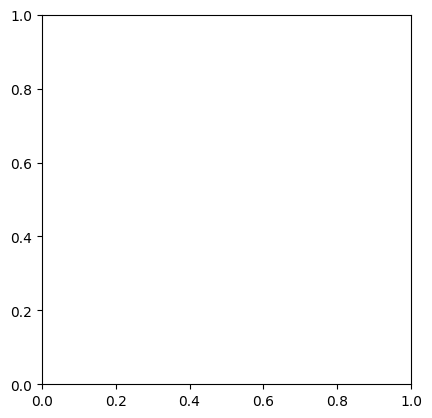

In [232]:
plt.imshow(prediction_mask[0])
plt.gca().set_aspect(100)
plt.colorbar()
plt.show()

In [233]:
prediction_mask[0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [231]:
prediction_mask.shape

torch.Size([2, 704])

In [101]:
past_is_pad

NameError: name 'past_is_pad' is not defined

In [96]:
label[1][-4]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [156]:
observed_mask[0]

tensor([[False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [142]:
sample_id[2].reshape((4,-1))

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
plt.imshow(padded_data.detach())
plt.colorbar()
plt.show()

In [33]:
from torch.nn.utils.rnn import pad_sequence
sequences = [torch.tensor([[1, 2, 3, 4], 
                           [5, 6, 7, 8]]),  # shape (2, 4)
             
             torch.tensor([[1, 2, 3], 
                           [4, 5, 6], 
                           [7, 8, 9], 
                           [10, 11, 12]]),  # shape (4, 3)
             
             torch.tensor([[1, 2], 
                           [3, 4], 
                           [5, 6]])]  # shape (3, 2)




In [65]:
observed_mask

tensor([[[False, False, False,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]]])

# 1. Forecasting with Moirai

<img src="img/pred_def.png" alt="Drawing" style="width: 800px;"/>

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

In [104]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base"),
    prediction_length=0,
    context_length=21000,
    patch_size=128,
    num_samples=1,
    target_dim=4,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# # Time series values. Shape: (batch, time, variate)
# past_target = rearrange(
#     torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
# )
# # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
# past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
# past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

past_target = rearrange(
    torch.linspace(1, 2, steps=256), "t -> 1 t 1"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

target torch.Size([1, 2, 128])
observed_mask torch.Size([1, 2, 128]) tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True],
         [True, True, True, True, True, Tr

RuntimeError: The size of tensor a (2) must match the size of tensor b (165) at non-singleton dimension 1

In [82]:
rns = np.load('rns_data.npy')

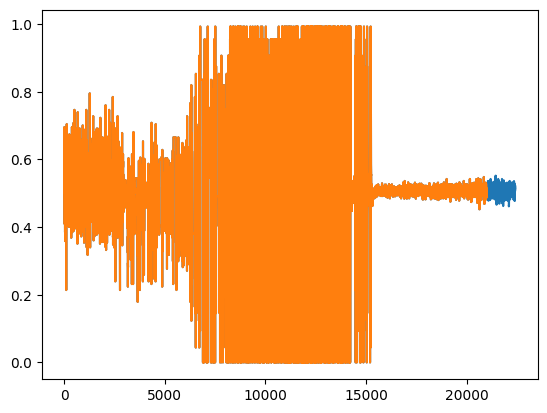

In [83]:
x_lab = np.linspace(1, rns[3].shape[0], rns[3].shape[0])
start_ind =0
end_ind = start_ind + 21000
plt.plot(x_lab, rns[3])

plt.plot(x_lab[start_ind:end_ind], rns[3][start_ind:end_ind])
plt.show()

In [90]:
15000/128

117.1875

In [105]:
from jaxtyping import Bool, Float, Int


def mask_fill(
        tensor: Float[torch.Tensor, "*batch dim"],
        mask: Bool[torch.Tensor, "*batch"],
        value: Float[torch.Tensor, "dim"],
) -> Float[torch.Tensor, "*batch dim"]:
    mask = mask.unsqueeze(-1)
    return tensor * ~mask + value * mask


def packed_attention_mask(
        sample_id: Int[torch.Tensor, "*batch seq_len"]
) -> Bool[torch.Tensor, "*batch seq_len seq_len"]:
    sample_id = sample_id.unsqueeze(-1)
    attention_mask = sample_id.eq(sample_id.mT)
    return attention_mask




In [106]:
rns[3].shape[0]/500

44.82

In [113]:
# torch.linspace(128, 2, steps=256), "t -> 1 t 1"
patch_size_int = 128
# past_target = rearrange(
#     torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
# )
start_ind = 0
emb_list = []
encode_list = []
for i in range(1):
    

    print(start_ind)
    end_ind = start_ind + 21000
    
    # past_target = rearrange(torch.as_tensor(rns[start_ind:end_ind], dtype=torch.float32), "t -> 1 t 4")
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_target = torch.as_tensor(rns[:, start_ind:end_ind]).T.unsqueeze(0).to(dtype=torch.float32)
    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)[:,:,0]
    print('past_is_pad', past_is_pad.shape)
    # past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)
    
    target, observed_mask, sample_id, time_id, variate_id, prediction_mask = model._convert(
        patch_size=patch_size_int,
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad, )
    print('target', target.shape)
    print('observed_mask', observed_mask.shape)
    print('sample_id', sample_id.shape)
    print('time_id', time_id.shape)
    print('variate_id', variate_id.shape)
    print('prediction_mask', prediction_mask.shape)
    patch_size = torch.tensor([patch_size_int]).repeat(1, target.shape[1])
    loc, scale = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").scaler(target,
                                                                                      observed_mask * ~prediction_mask.unsqueeze(
                                                                                          -1),
                                                                                      sample_id,
                                                                                      variate_id, )
    scaled_target = (target - loc) / scale
    reprs = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").in_proj(scaled_target, patch_size)

    masked_reprs = mask_fill(reprs, prediction_mask,
                             MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").mask_encoding.weight)
    encoded = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").encoder(
        masked_reprs,
        packed_attention_mask(sample_id),
        time_id=time_id,
        var_id=variate_id,
    )
    pooled = torch.mean(encoded, dim=1)
    emb_list.append(pooled)
    encode_list.append(encoded)
    
    start_ind = end_ind


0
past_is_pad torch.Size([1, 21000])
target torch.Size([1, 660, 128])
observed_mask torch.Size([1, 660, 128])
sample_id torch.Size([1, 660])
time_id torch.Size([1, 660])
variate_id torch.Size([1, 660])
prediction_mask torch.Size([1, 660])


In [114]:
variate_id

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [111]:
rns[:, start_ind:end_ind].shape

(4, 22410)

In [101]:
torch.as_tensor(rns[start_ind:end_ind]).T.unsqueeze(0).shape

torch.Size([1, 22410, 4])

In [88]:
encode_list[0].shape

torch.Size([1, 165, 768])

In [71]:
118*128

15104

In [66]:
emb_list = torch.concat(emb_list)

In [67]:
emb_list

tensor([[-8.8792e-09,  9.0251e-09, -1.2129e-09,  2.1430e-01, -1.3066e-07,
          1.3727e-07, -3.1911e-11, -1.6066e-01,  1.1296e-07, -1.7839e-07,
          1.1222e-01,  9.3753e-09, -6.8327e-09, -8.1742e-09,  1.0738e-08,
          2.1669e-08, -5.5861e-09,  3.4146e-08, -1.8069e-09, -4.4079e-08,
         -8.7868e-09, -4.2406e-08, -1.6847e-01, -3.9573e-08, -7.2488e-09,
         -4.6676e-09,  3.3481e-08,  2.8609e-08,  4.2737e-08,  4.5793e-01,
          2.0278e-08, -8.0962e-08, -4.7431e-08,  1.7399e-08,  1.1557e-07,
          2.0140e-08, -1.4046e-08, -2.6890e-07,  3.0201e-02,  1.5737e-08,
         -7.6228e-08,  4.4162e-09,  1.3986e-08, -1.9301e-01,  2.0498e-07,
          5.4293e-02,  2.6818e-08, -1.3262e-06,  3.6206e-09,  2.1460e-01,
         -7.5780e-07,  3.5692e-02, -1.1633e-09, -4.6869e-08, -1.0221e-07,
          2.3864e-09,  5.3919e-08, -1.5086e-02,  2.9230e-06,  1.4129e-08,
         -5.8802e-10,  3.2513e-08, -1.7717e-08, -6.3963e-09, -1.2706e-08,
          1.9985e-08, -1.3157e-06, -3.

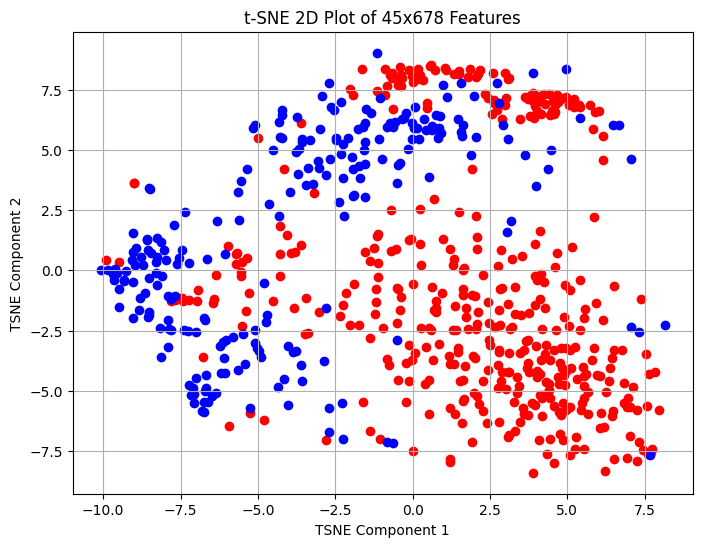

In [130]:
from sklearn.manifold import TSNE

# Example feature matrix of shape [45, 678]
X = encode_list[0][0].detach().numpy()

# Perform t-SNE to reduce dimensions from 678 to 2
tsne = TSNE(n_components=2, random_state=42,perplexity=100)
X_tsne = tsne.fit_transform(X)

# Plot the 2D t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:165*2, 0], X_tsne[:165*2, 1], c = 'r')
plt.scatter(X_tsne[165*2+118:165+165*2, 0], X_tsne[165*2+118:165+165*2, 1], c = 'r')
plt.scatter(X_tsne[165*3+118:165+165*3, 0], X_tsne[165*3+118:165+165*3, 1], c = 'r')
plt.scatter(X_tsne[165*3:118+165*3, 0], X_tsne[165*3:118+165*3, 1], c = 'b')
plt.scatter(X_tsne[165*2:118+165*2, 0], X_tsne[165*2:118+165*2, 1], c = 'b')

# plt.scatter(X_tsne[47:118, 0], X_tsne[47:118, 1], c = 'b')
# plt.scatter(X_tsne[118:, 0], X_tsne[118:, 1], c = 'c')

plt.title('t-SNE 2D Plot of 45x678 Features')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.grid(True)
plt.show()
# MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small")(target  =target, observed_mask = observed_mask, sample_id = sample_id, time_id = time_id, variate_id =variate_id, prediction_mask = prediction_mask, patch_size = patch_size)

In [ ]:
X_tsne

In [128]:
X_tsne.reshape(4,-1,2).shape

(4, 165, 2)

In [ ]:
plt.scatter(X_tsne[:165*2, 0], X_tsne[:165*2, 1], c = 'r')
plt.scatter(X_tsne[165*2+118:165+165*2, 0], X_tsne[165*2+118:165+165*2, 1], c = 'r')
plt.scatter(X_tsne[165*3+118:165+165*3, 0], X_tsne[165*3+118:165+165*3, 1], c = 'r')
plt.scatter(X_tsne[165*3:118+165*3, 0], X_tsne[165*3:118+165*3, 1], c = 'b')
plt.scatter(X_tsne[165*2:118+165*2, 0], X_tsne[165*2:118+165*2, 1], c = 'b')

In [120]:
encode_list[0][0].shape[0]/4

165.0

In [30]:
X_tsne

array([[1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1245.7596   ,   13.546299 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
       [1284.2662   ,    6.267781 ],
 

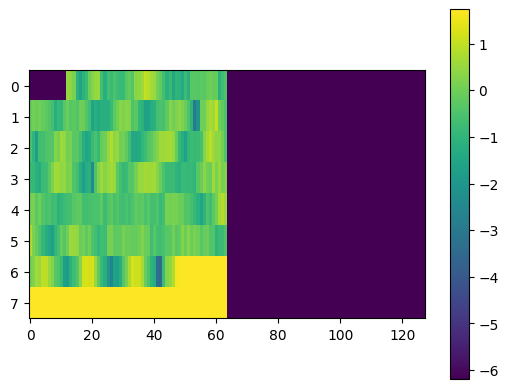

In [15]:
plt.imshow(scaled_target[0])
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()

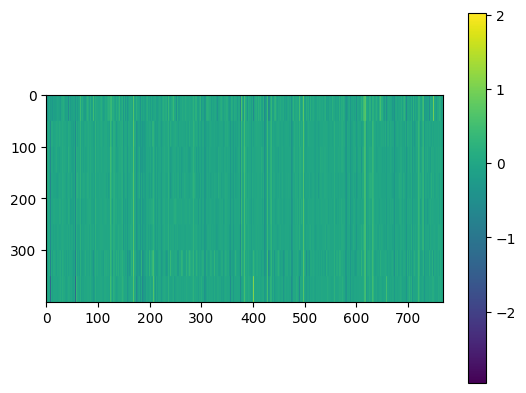

In [16]:
plt.imshow(reprs.detach().repeat_interleave(repeats=50, dim=1)[0])
plt.colorbar()
plt.show()

In [214]:
# masked_reprs = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").mask_fill(reprs, prediction_mask, MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small").mask_encoding.weight)
from typing import Optional


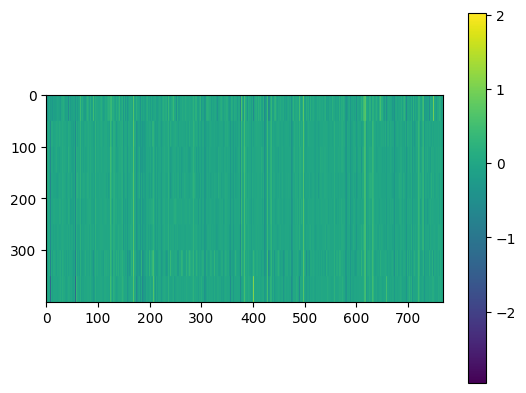

In [17]:
plt.imshow(masked_reprs.detach().repeat_interleave(repeats=50, dim=1)[0])
plt.colorbar()
plt.show()

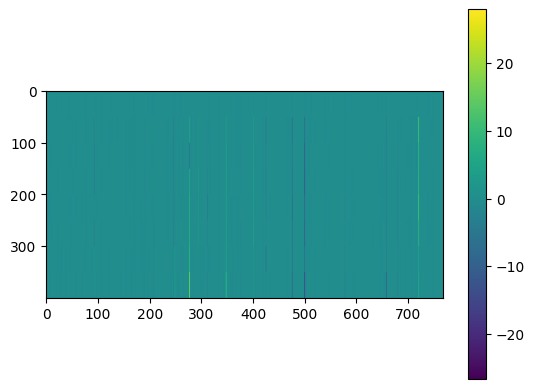

In [18]:
plt.imshow(encoded.detach().repeat_interleave(repeats=50, dim=1)[0])
plt.colorbar()
plt.show()

In [218]:
distr_param = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").param_proj(encoded, patch_size)
print('distr_param', distr_param['weights_logits'].shape, distr_param['components'])
distr = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").distr_output.distribution(distr_param, loc=loc,
                                                                                                scale=scale)

distr_param torch.Size([1, 7, 128, 4]) [{'df': tensor([[[2.8830, 2.8683, 2.7895, 2.7313, 2.6945, 2.6530, 2.6438, 2.6451,
          2.6499, 2.6700, 2.7063, 2.7421, 2.8028, 2.8522, 2.8758, 2.8988,
          2.9395, 3.0216, 3.0175, 3.0184, 3.0472, 3.0843, 3.0997, 3.1344,
          3.1802, 3.2215, 3.2106, 3.2134, 3.2129, 3.1836, 3.1499, 3.1204,
          3.0856, 3.0423, 2.9768, 2.9352, 2.8373, 2.8111, 2.7213, 2.6359,
          2.5904, 2.5096, 2.4315, 2.3703, 2.3094, 2.2778, 2.2340, 2.2101,
          2.1794, 2.1796, 2.1551, 2.1163, 2.0986, 2.0870, 2.0753, 2.0675,
          2.0613, 2.0585, 2.0557, 2.0546, 2.0536, 2.0504, 2.0501, 2.0462,
          2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931,
          2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931,
          2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931,
          2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931,
          2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931, 2.6931,

In [219]:
MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").mask_encoding.weight

Parameter containing:
tensor([[ 7.8602e-02, -1.4489e-02, -2.6295e-02,  4.4188e-02,  1.3299e-01,
          1.4428e+00,  1.2081e-02, -1.0378e-02, -2.4239e+00,  4.4473e-02,
          1.4395e-02,  2.5981e-02, -4.5673e-02, -3.7598e-02,  7.2712e-02,
          3.6243e-03,  2.7508e-02,  8.1042e-02,  6.8250e-02,  9.7940e-02,
         -5.0652e-03, -4.1927e-02,  4.1756e-03, -6.3132e-02,  2.6086e-02,
         -2.3266e-02,  2.4092e-02, -5.6187e-01, -2.9968e-02,  4.5493e-02,
         -1.1160e-02, -3.4051e-02,  1.4679e+00, -3.5937e-03, -1.0282e-02,
          6.9586e-02, -1.2216e-01,  5.0514e-02,  8.3050e-03, -2.3494e-02,
          1.2660e-02, -4.1707e-02,  4.1932e-02, -3.8203e-02, -9.8983e-03,
          6.2717e-02,  4.0011e-02,  9.0618e-02,  1.6752e-02,  4.1088e-03,
          5.5471e-02,  3.7162e-02, -1.8493e+00, -9.8536e-03, -5.0590e-02,
         -5.6826e-02, -2.8911e-02, -2.4655e+00, -5.5829e+00,  7.2537e-02,
          1.1871e-01,  3.0300e-01,  8.7920e-02, -1.9969e-01, -1.1984e-01,
          4.9439

In [220]:
from torch import nn

nn.Embedding(1, 384).weight

Parameter containing:
tensor([[ 1.2610, -1.3427,  0.8935,  1.5676,  0.0904,  0.1564, -0.8317, -1.3064,
         -0.0755,  0.4365,  1.3155, -1.2678,  0.8932,  0.2223,  0.0910, -0.6737,
          0.4647,  0.9131,  0.7184, -1.3435,  0.0584,  0.7908,  0.7840, -1.2238,
         -1.1587,  0.1330, -0.2035,  1.5508,  0.6177,  0.6458,  0.9032, -0.4855,
          0.5379,  0.0466, -1.3300, -0.3172,  0.5365, -0.5998, -0.7799,  1.7510,
          0.0492,  0.7321, -0.3224, -0.6301,  0.8017,  1.0321,  0.2040, -0.3539,
         -0.2029,  0.1566,  0.5266, -1.1983,  1.5119, -1.0713,  1.4509, -2.1608,
         -1.4459,  1.8508, -0.3526,  1.8472, -1.0464, -1.1463, -1.6880, -0.5622,
         -0.4517,  0.7196,  1.4738,  0.2667, -1.2112, -0.1101,  1.7238, -0.3268,
          0.5476, -0.5471,  3.1108, -1.5685,  1.1297, -0.6692,  1.8231,  0.2771,
          0.1218, -0.6697,  0.6054,  0.2701, -0.6444,  0.9134, -0.7142,  0.7203,
          0.4017, -2.4079, -0.7989, -0.5560, -0.6937, -0.7096,  0.0175, -0.4104,
      

In [221]:
MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").param_proj

DistrParamProj(
  (proj): ModuleDict(
    (weights_logits): MultiOutSizeLinear(in_features=768, out_features_ls=(32, 64, 128, 256, 512), bias=True, dtype=torch.float32)
    (components): ModuleList(
      (0): ModuleDict(
        (df): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
        (loc): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
        (scale): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
      )
      (1): ModuleDict(
        (loc): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
      )
      (2): ModuleDict(
        (total_count): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
        (logits): MultiOutSizeLinear(in_features=768, out_features_ls=(8, 16, 32, 64, 128), bias=True,

In [222]:
preds = distr.sample(torch.Size((100,)))

In [223]:
preds.size()

torch.Size([100, 1, 7, 128])

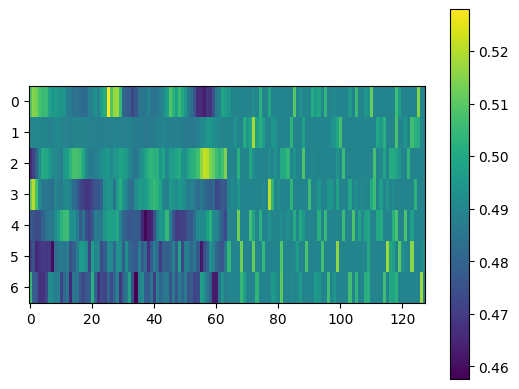

In [224]:
reformated = np.median(preds, axis=0)
plt.imshow(reformated[0])
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()

In [225]:
reformated[0, 2:4, :32].flatten()

array([0.46592832, 0.47172982, 0.48034543, 0.4913868 , 0.5007838 ,
       0.49945238, 0.49637574, 0.49121943, 0.4912268 , 0.48958933,
       0.4872648 , 0.4953017 , 0.49703592, 0.5030403 , 0.50762177,
       0.50709087, 0.5052255 , 0.49922   , 0.49006596, 0.4865743 ,
       0.48624876, 0.4882805 , 0.48940676, 0.4919816 , 0.4940046 ,
       0.4950894 , 0.49068058, 0.49417505, 0.49535602, 0.4986611 ,
       0.4977169 , 0.49557933, 0.5126001 , 0.52045715, 0.50681484,
       0.49301907, 0.48556173, 0.48560995, 0.48493356, 0.48310173,
       0.48911572, 0.4873641 , 0.4864934 , 0.4911949 , 0.49124473,
       0.48865956, 0.482387  , 0.4787236 , 0.47252148, 0.4704556 ,
       0.46883935, 0.4688707 , 0.47307664, 0.47616696, 0.47685832,
       0.48013222, 0.49232715, 0.4941473 , 0.49333084, 0.4845456 ,
       0.49550086, 0.5019342 , 0.4939093 , 0.48932344], dtype=float32)

In [146]:
reformated = model._format_preds(patch_size_int, preds, past_target.shape[-1])[0]

In [147]:
reformated.shape

torch.Size([100, 256])

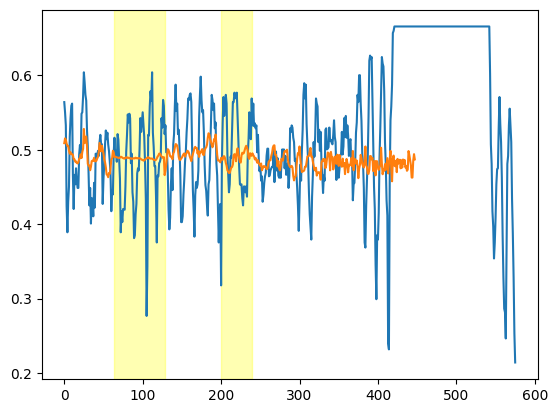

In [226]:
plt.plot(rns[3][start_ind:end_ind + 256])
plt.plot(reformated[0, :, :64].flatten())
plt.axvspan(64, 128, color='yellow', alpha=0.3)
plt.axvspan(200, 240, color='yellow', alpha=0.3)


In [149]:
reformated[0, :, :32].flatten()[32 * 7 - 200: 32 * 7]

IndexError: too many indices for tensor of dimension 2

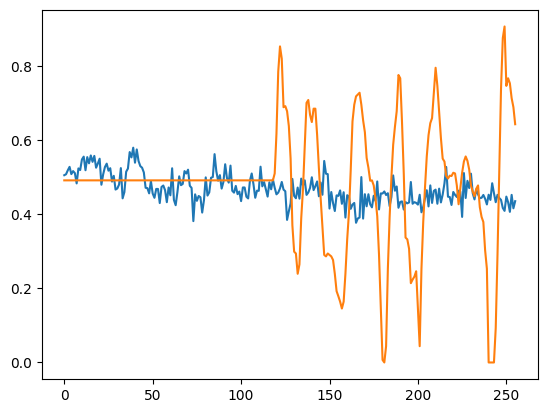

In [151]:
plt.plot(np.median(reformated, 0))
plt.plot(rns[3][end_ind:end_ind + 256])

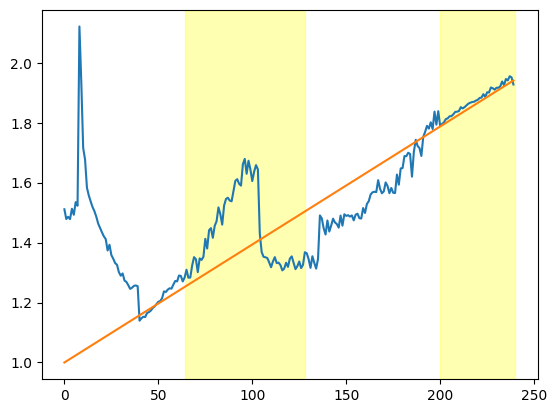

In [1415]:
plt.plot(reformated[0, :, :32].flatten()[32 * 7 - 200: 32 * 7 - 200 + 240])
plt.plot((x / 20 + 1)[:240])
plt.axvspan(64, 128, color='yellow', alpha=0.3)
plt.axvspan(200, 240, color='yellow', alpha=0.3)


In [ ]:
sum

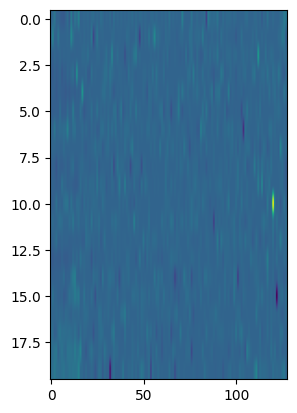

In [394]:
from functools import partial
from torchsummary import summary

summary(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base")(target=torch.ones((1, 8, 128)), observed_mask=
torch.zeros((1, 8, 128), dtype=bool),
                                                                      sample_id=torch.Tensor(
                                                                          [[1, 1, 1, 1, 1, 1, 1, 1]]).to(
                                                                          dtype=torch.int32),
                                                                      time_id=torch.Tensor(
                                                                          [[0, 1, 2, 3, 4, 5, 6, 7]]).to(
                                                                          dtype=torch.int32),
                                                                      variate_id=torch.Tensor(
                                                                          [[0, 0, 0, 0, 0, 0, 0, 0]]).to(
                                                                          dtype=torch.int32),
                                                                      prediction_mask=torch.Tensor([[False, False,
                                                                                                     False, False,
                                                                                                     False, False, True,
                                                                                                     True]]).to(
                                                                          dtype=torch.bool),
                                                                      patch_size=torch.Tensor(
                                                                          [[32, 32, 32, 32, 32, 32, 32, 32]]).to(
                                                                          dtype=torch.int32),

                                                                      ), input_size=(1, 8, 128))

target torch.Size([1, 8, 128])
observed_mask torch.Size([1, 8, 128]) tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
sample_id torch.Size([1, 8]) tensor([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)
time_id torch.Size([1, 8]) tensor([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=torch.int32)
variate_id torch.Size([1, 8]) tensor([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
prediction_mask torch.Size([1, 8]) tensor([[False, False, False, False, False, False,  True,  True]])
patch_size torch.Size([1, 8]) tensor([[32, 32, 32, 32, 32, 32, 32, 32]], dtype=torch.int32)
loc torch.Size([1, 8, 1]) tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
   

AttributeError: 'AffineTransformed' object has no attribute 'apply'

In [1417]:
summary(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").encoder.to('cuda'), input_size=(1, 8, 384 * 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           RMSNorm-1            [-1, 1, 8, 768]             768
            Linear-2            [-1, 1, 8, 768]         589,824
            Linear-3            [-1, 1, 8, 768]         589,824
            Linear-4            [-1, 1, 8, 768]         589,824
           RMSNorm-5      [-1, 1, 12, 1, 8, 64]              64
           RMSNorm-6      [-1, 1, 12, 1, 8, 64]              64
BinaryAttentionBias-7       [-1, 1, 12, 1, 8, 8]               0
  RotaryProjection-8      [-1, 1, 12, 1, 8, 32]               0
  RotaryProjection-9      [-1, 1, 12, 1, 8, 32]               0
 RotaryProjection-10      [-1, 1, 12, 1, 8, 32]               0
 RotaryProjection-11      [-1, 1, 12, 1, 8, 32]               0
 RotaryProjection-12      [-1, 1, 12, 1, 8, 32]               0
 RotaryProjection-13      [-1, 1, 12, 1, 8, 32]               0
 RotaryProjection-14      [-1, 1, 12, 

C:\Users\Patrick Xu\Desktop\uni2ts\venv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


In [62]:
MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base")(target=torch.ones((1, 8, 128)),
                                                              observed_mask=torch.zeros((1, 8, 128), dtype=bool),
                                                              sample_id=torch.Tensor([[1, 1, 1, 1, 1, 1, 1, 1]]).to(
                                                                  dtype=torch.int32),
                                                              time_id=torch.Tensor([[0, 1, 2, 3, 4, 5, 6, 7]]).to(
                                                                  dtype=torch.int32),
                                                              variate_id=torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0]]).to(
                                                                  dtype=torch.int32),
                                                              prediction_mask=torch.Tensor([[False, False, False,
                                                                                             False, False, False, True,
                                                                                             True]]).to(
                                                                  dtype=torch.bool),
                                                              patch_size=torch.Tensor(
                                                                  [[16, 16, 16, 16, 16, 16, 16, 16]]).to(
                                                                  dtype=torch.int32))

target torch.Size([1, 8, 128])
observed_mask torch.Size([1, 8, 128]) tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
sample_id torch.Size([1, 8]) tensor([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)
time_id torch.Size([1, 8]) tensor([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=torch.int32)
variate_id torch.Size([1, 8]) tensor([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
prediction_mask torch.Size([1, 8]) tensor([[False, False, False, False, False, False,  True,  True]])
patch_size torch.Size([1, 8]) tensor([[16, 16, 16, 16, 16, 16, 16, 16]], dtype=torch.int32)
loc torch.Size([1, 8, 1]) tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
   

tensor([[[ 1.6470e-03, -2.1304e-03,  1.4865e+00,  ...,  1.0158e-04,
           3.8918e-03, -1.0143e+00],
         [ 1.6594e-03, -2.1912e-03,  1.4864e+00,  ...,  1.1186e-04,
           3.8998e-03, -1.0141e+00],
         [ 1.6563e-03, -2.1281e-03,  1.4855e+00,  ...,  6.7312e-05,
           3.9106e-03, -1.0147e+00],
         ...,
         [ 1.6329e-03, -3.7949e-03,  1.4858e+00,  ..., -8.6310e-05,
           3.8060e-03, -1.0136e+00],
         [ 1.5729e-03,  4.0562e-02, -6.2355e-01,  ...,  2.0225e-02,
           4.1076e-03,  1.3198e+00],
         [ 5.1567e-04,  3.3559e-02, -4.2882e-01,  ...,  2.6253e-02,
          -3.0613e-03,  1.2892e+00]]], grad_fn=<MulBackward0>)

In [41]:
partial_class = lambda observed_mask, sample_id, time_id, variate_id, prediction_mask,
                       patch_size: MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base")(observed_mask=
torch.zeros(
    (1, 8, 128),
    dtype=bool),
    sample_id=torch.Tensor(
        [[1, 1, 1, 1, 1, 1,
          1, 1]]).to(
        dtype=torch.int32),
    time_id=torch.Tensor([[
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7]]).to(
        dtype=torch.int32),
    variate_id=torch.Tensor(
        [[0, 0, 0, 0, 0, 0,
          0, 0]]).to(
        dtype=torch.int32),
    prediction_mask=torch.Tensor(
        [[False, False,
          False, False,
          False, False,
          True, True]]).to(
        dtype=torch.bool),
    patch_size=torch.Tensor(
        [[32, 32, 32, 32,
          32, 32, 32,
          32]]).to(
        dtype=torch.int32))

In [45]:
MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base")

TypeError: Module.apply() missing 1 required positional argument: 'fn'

In [246]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=4),
)
print("ground truth:\n", label["target"])

median prediction:
 [1.9974 2.0191 1.9873 2.041  2.0412 2.0001 2.0314 2.0632 2.0238 2.0426
 2.0244 2.0536 2.0783 1.9824 2.0653 2.0437 2.0788 2.0791 2.0497 2.0905
 2.1916 2.2011 2.0731 2.0862 2.1497 2.1321 2.1956 2.196  2.1165 2.0589
 2.1711 2.1142 2.2118 2.164  2.1113 2.0946 2.1299 2.0681 2.0107 2.1646
 2.117  2.0474 2.1139 2.1796 2.2493 2.128  2.1622 2.311 ]
ground truth:
 [-0.5511 -0.5932 -0.7505 -0.4978 -0.5051 -0.3753 -0.244   0.0095  0.3692
  0.7807  1.0135  1.1805  1.5927  1.6855  1.8593  1.685   1.5527  1.3677
  1.1558  0.8158  0.3267  0.1822 -0.427  -0.8917 -1.3495 -1.6403 -1.8952
 -1.9084 -1.8111 -1.7865 -1.7594 -1.2197 -1.3027 -1.0029 -0.5541  0.037
  0.1842  0.4091  0.5988  0.9457  1.0123  0.8828  1.0167  0.6306  0.3671
  0.2454  0.0181 -0.3464]


In [63]:
summary(MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base").decoder.to('cuda'), input_size=(1, 168, 384))

AttributeError: 'MoiraiModule' object has no attribute 'decoder'

In [266]:
preds.shape

torch.Size([100, 1, 5, 128])

In [65]:
from transformers import AutoModel

model = AutoModel.from_pretrained("Salesforce/moirai-1.1-R-base")

ValueError: Unrecognized model in Salesforce/moirai-1.1-R-small. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, audio-spectrogram-transformer, autoformer, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, deta, detr, dinat, dinov2, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, git, glpn, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, graphormer, grounding-dino, groupvit, hiera, hubert, ibert, idefics, idefics2, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava-next-video, llava_next, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mistral, mixtral, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, pix2struct, plbart, poolformer, pop2piano, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_moe, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, siglip, siglip_vision_model, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, time_series_transformer, timesformer, timm_backbone, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zoedepth

# 2. Rolling Evaluation

<img src="img/rolling_eval.png" alt="Drawing" style="width: 800px;"/>

As shown in the above plot, we use GluonTS to construct rolling window evaluation

## Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [567]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 32  # prediction length: any positive integer
CTX = 192  # context length: any positive integer
PSZ = 32  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 1  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

## 2.1 Loading from a _long_ DataFrame

In [68]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [69]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [70]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [540]:
next(iter(test_data.input))['target']

array([[-1.3378, -1.6111, -1.9259, ...,  1.3527,  1.078 ,  0.7592],
       [ 0.1268,  0.0926, -0.142 , ...,  0.543 ,  0.5423,  0.7687],
       [-0.3645, -0.1364,  0.1063, ...,  0.1352, -0.1565, -0.3939],
       ...,
       [-0.7917, -0.9609, -0.9034, ..., -0.4035, -0.5445, -0.5025],
       [ 0.7071,  0.6413,  0.4323, ...,  0.863 ,  0.9726,  1.0554],
       [ 1.3763,  1.275 ,  0.6767, ...,  0.719 ,  1.0701,  1.0008]],
      dtype=float32)

In [71]:
predictor.prediction_net.module

MoiraiModule(
  (mask_encoding): Embedding(1, 384)
  (scaler): PackedStdScaler()
  (in_proj): MultiInSizeLinear(in_features_ls=[8, 16, 32, 64, 128], out_features=384, bias=True, dtype=torch.float32)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): GroupedQueryAttention(
          (var_attn_bias): BinaryAttentionBias(
            (emb): Embedding(2, 6)
          )
          (time_qk_proj): QueryKeyProjection(
            (query_proj): RotaryProjection()
            (key_proj): RotaryProjection()
          )
          (q_proj): Linear(in_features=384, out_features=384, bias=False)
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=False)
          (q_norm): RMSNorm(normalized_shape=(64,), eps=1e-05, weight=True)
          (k_norm): RMSNorm(normalized_shape=(64,), eps=1e-05, weight=True)
          (out_proj): Linear(in_features=

target torch.Size([32, 28, 128])
observed_mask torch.Size([32, 28, 128]) tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         .

C:\Users\Patrick Xu\Desktop\uni2ts\src\uni2ts\module\attention.py:296: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(


[{'df': tensor([[[2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         ...,
         [2.2082, 2.1648, 2.1537,  ..., 2.6931, 2.6931, 2.6931],
         [2.1922, 2.1515, 2.1417,  ..., 2.6931, 2.6931, 2.6931],
         [2.1910, 2.1492, 2.1381,  ..., 2.6931, 2.6931, 2.6931]],

        [[2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         ...,
         [2.1469, 2.1200, 2.1165,  ..., 2.6931, 2.6931, 2.6931],
         [2.1698, 2.1352, 2.1283,  ..., 2.6931, 2.6931, 2.6931],
         [2.1653, 2.1298, 2.1220,  ..., 2.6931, 2.6931, 2.6931]],

        [[2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.6931, 2.6931],
         [2.3631, 2.3056, 2.2869,  ..., 2.6931, 2.

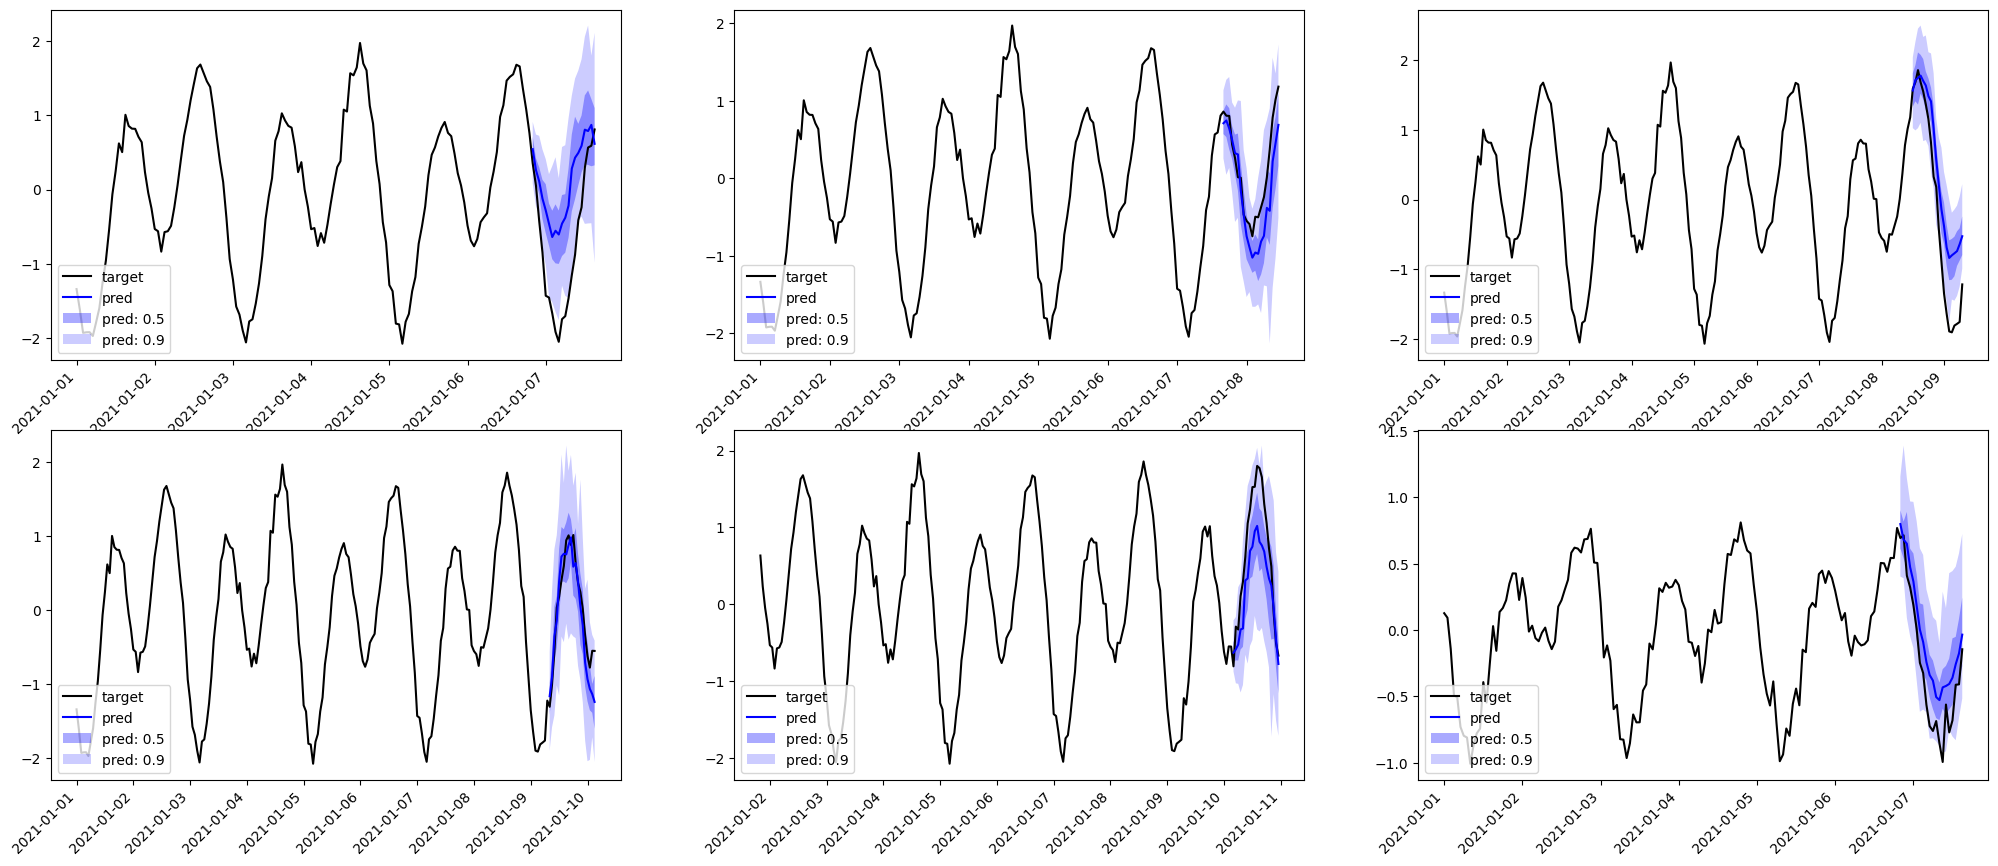

In [72]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

## 2.2 Loading from a _wide_ DataFrame

In [57]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [58]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [59]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

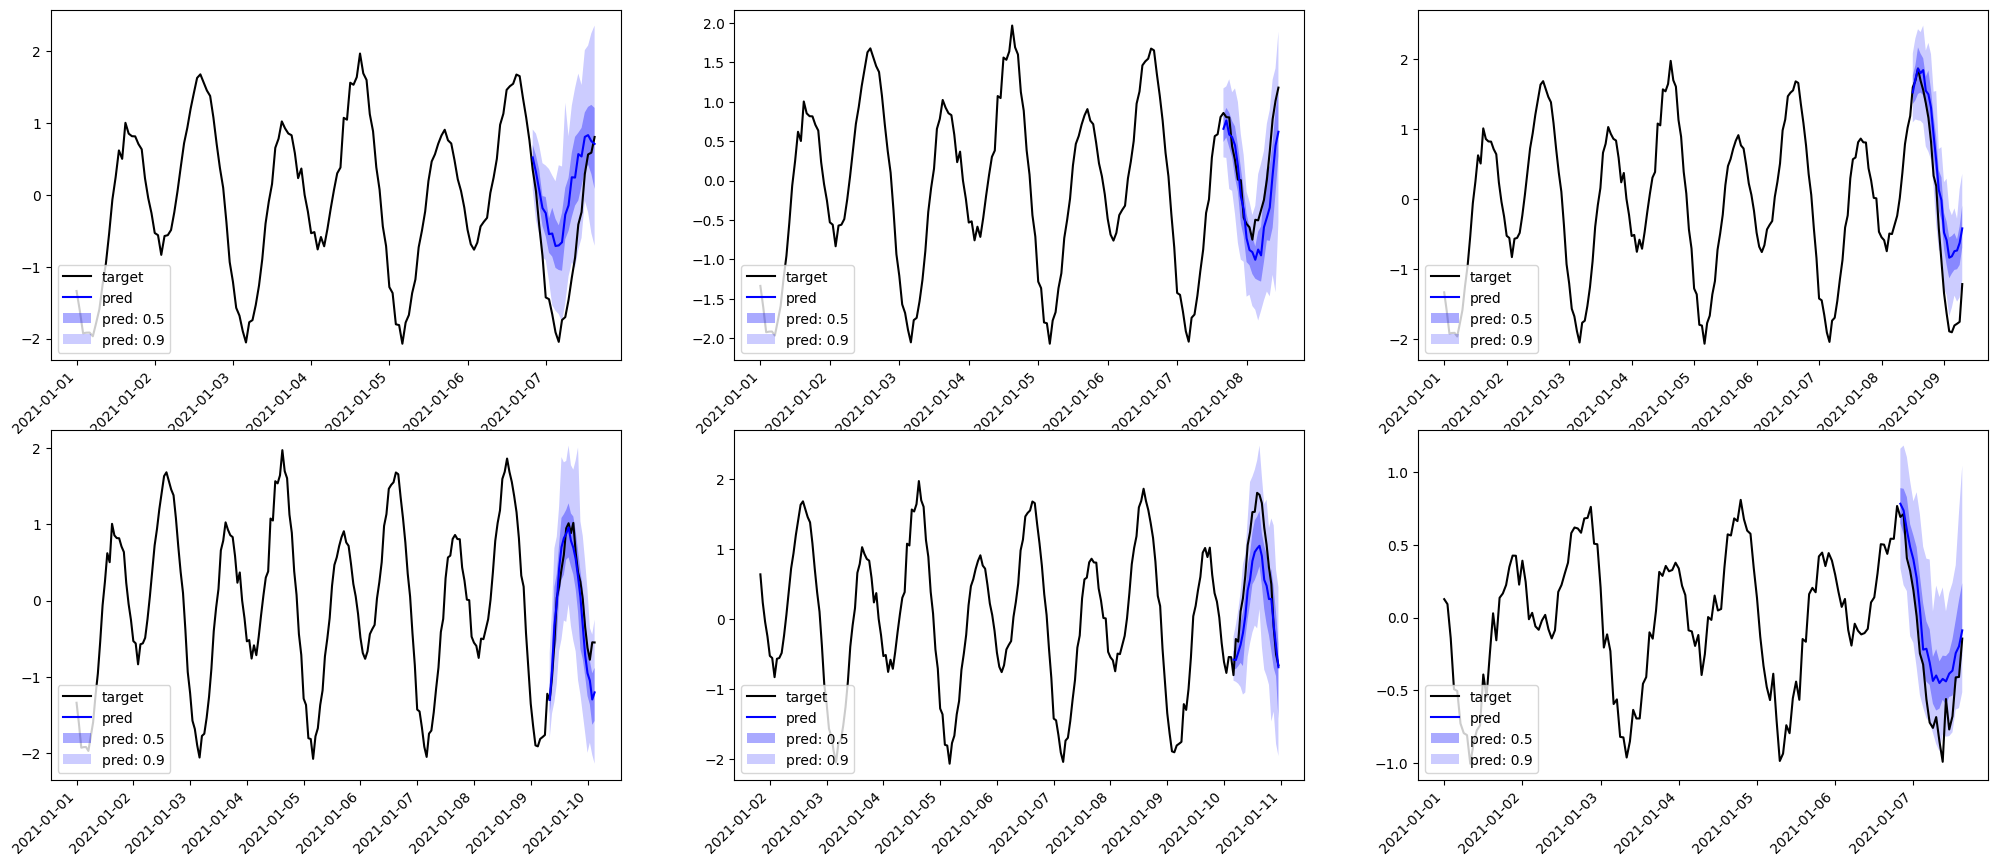

In [60]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 2.3 Multivariate Forecasting

In [579]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)
df = df.loc[:, ["A", "B", "C"]]

In [580]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [581]:
multivar_ds[0]['target'].shape

(3, 240)

In [582]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=len(ds),
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [583]:
# Make predictions
# inp = next(input_it)
# label = next(label_it)
forecast = next(forecast_it)

target torch.Size([1, 21, 128])
observed_mask torch.Size([1, 21, 128]) tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]], device='cuda:0')
sample_id torch.Size([1, 21]) tensor([[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0', dtype=torch.int32)
time_id torch.Size([1, 21]) tensor([[0, 0, 1, 2, 3, 4, 0, 0, 1, 2, 3, 4, 0, 0, 1, 2, 3, 4, 5, 5, 5]],
       device='cuda:0')
variate_id torch.Size([1, 21]) tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2]],
       device='cuda:0')
prediction_mask torch.Size([1, 21]) tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, Fa

In [77]:
next(iter(test_data.input))

{'start': Period('2021-01-01 00:00', 'H'),
 'target': array([-1.3378e+00, -1.6111e+00, -1.9259e+00, -1.9184e+00, -1.9168e+00,
        -1.9681e+00, -1.7846e+00, -1.5927e+00, -1.2477e+00, -9.5600e-01,
        -5.3710e-01, -6.3500e-02,  2.4840e-01,  6.2010e-01,  5.0230e-01,
         1.0044e+00,  8.5350e-01,  8.1800e-01,  8.1540e-01,  7.0800e-01,
         6.3530e-01,  2.3250e-01, -4.4800e-02, -2.5390e-01, -5.3010e-01,
        -5.6040e-01, -8.3440e-01, -5.7200e-01, -5.6040e-01, -4.8820e-01,
        -2.4090e-01,  5.6700e-02,  3.9530e-01,  7.2090e-01,  9.3600e-01,
         1.1985e+00,  1.4179e+00,  1.6294e+00,  1.6792e+00,  1.5665e+00,
         1.4542e+00,  1.3784e+00,  1.0784e+00,  7.0940e-01,  3.7570e-01,
         1.0000e-01, -3.8050e-01, -9.3510e-01, -1.2102e+00, -1.5725e+00,
        -1.6813e+00, -1.8947e+00, -2.0547e+00, -1.7722e+00, -1.7434e+00,
        -1.5327e+00, -1.2614e+00, -8.9450e-01, -3.9980e-01, -9.3100e-02,
         1.5230e-01,  6.5690e-01,  7.8350e-01,  1.0239e+00,  9.2650e-01

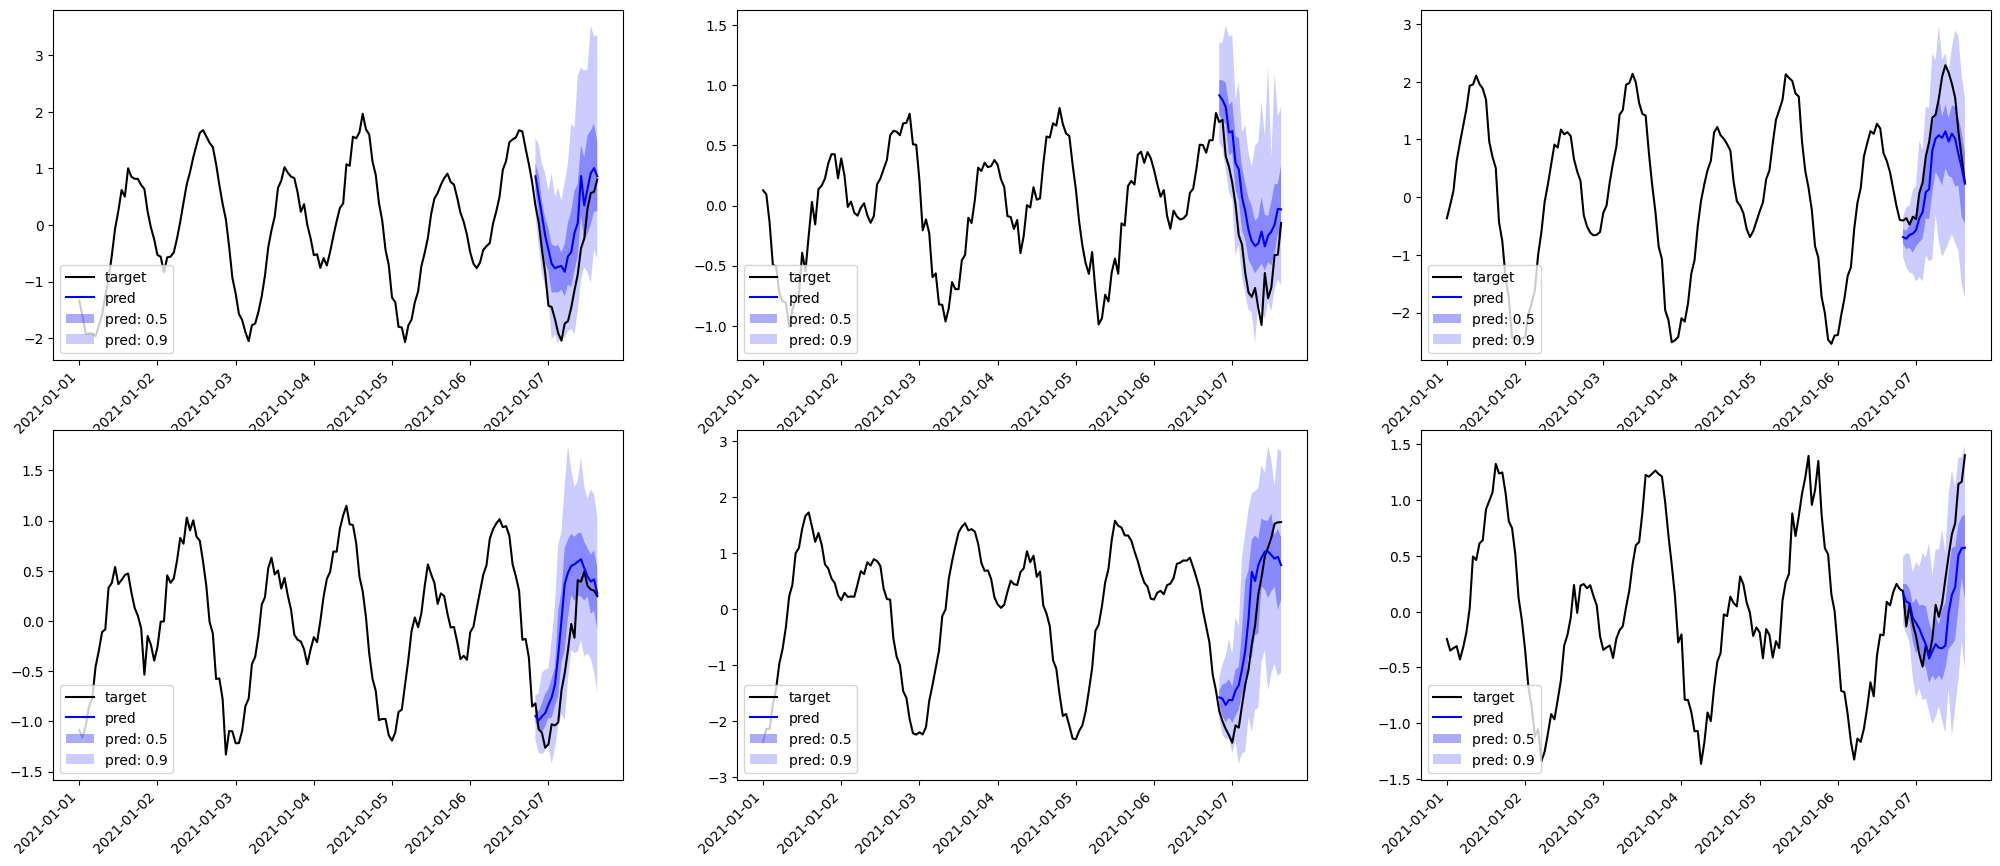

In [65]:
# Visualize different dimensions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

## 2.4 Include dynamic features

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

In [66]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
T = df.shape[0]
df["dynamic_real_1"] = np.random.normal(size=T)
df["past_dynamic_real_2"] = np.random.normal(size=T)

In [67]:
ds = PandasDataset.from_long_dataframe(
    df,
    item_id="item_id",
    past_feat_dynamic_real=["past_dynamic_real_2"],
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [68]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

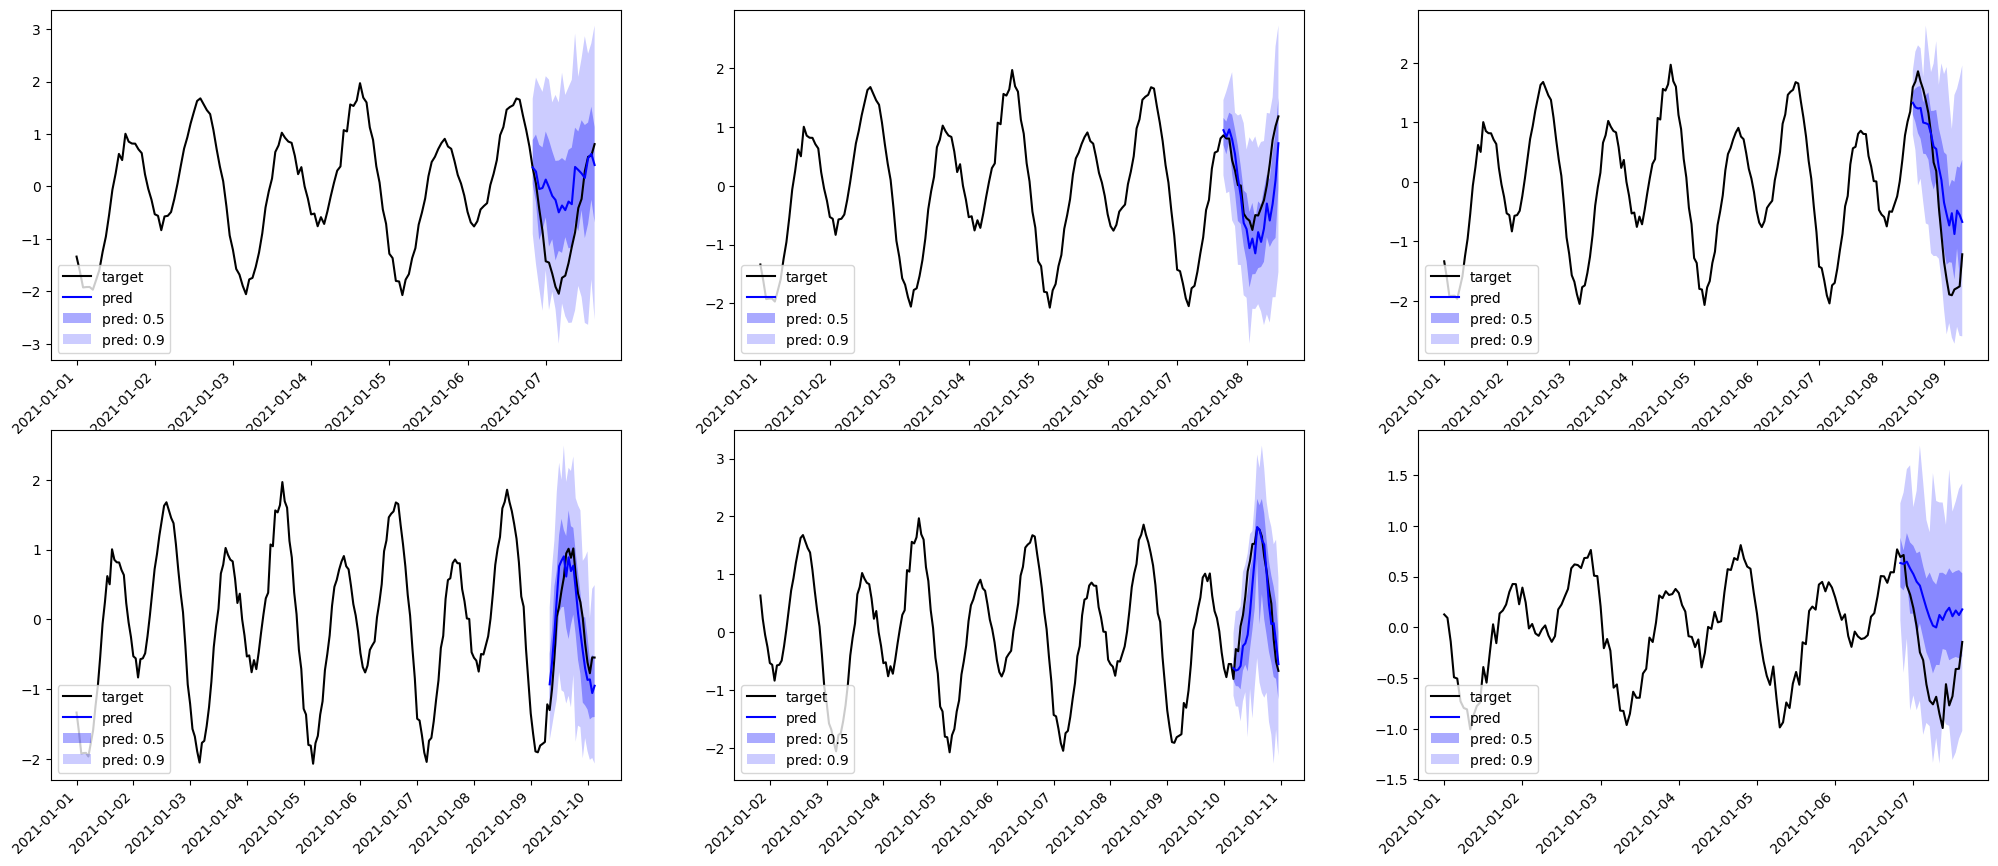

In [69]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

In [70]:
torch.cuda.is_available()

True